In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import drive
from matplotlib import font_manager, rc
from tqdm import tqdm
import warnings
import seaborn as sns
import random

#drive.mount('/content/drive')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
cust_train = pd.read_csv('C:/Users/leeji/ML_Session(D&A)/Dataset/cust_train.csv')
cust_test = pd.read_csv('C:/Users/leeji/ML_Session(D&A)/Dataset/sample_submission.csv')
product_train = pd.read_csv('C:/Users/leeji/ML_Session(D&A)/Dataset/product_train.csv')
product_test = pd.read_csv('C:/Users/leeji/ML_Session(D&A)/Dataset/product_test.csv')
session_train = pd.read_csv('C:/Users/leeji/ML_Session(D&A)/Dataset/session_train.csv')
session_test = pd.read_csv('C:/Users/leeji/ML_Session(D&A)/Dataset/session_test.csv')
master = pd.read_csv('C:/Users/leeji/ML_Session(D&A)/Dataset/master.csv')

In [33]:
data = pd.read_csv('C:/Users/leeji/ML_Session(D&A)/Dataset/김이조 data 최종.csv', encoding = 'utf-8')
data_te = pd.read_csv('C:/Users/leeji/ML_Session(D&A)/Dataset/김이조 data_te 최종.csv', encoding = 'utf-8')

In [4]:
label = cust_train.LABEL
label = label.map({"F20" : 0, "F30" : 1, "F40" : 2, "M20" : 3, "M30" : 4, "M40" : 5})

In [5]:
train = pd.merge(product_train, session_train, on = ['CLNT_ID','SESS_ID'])
train = pd.merge(train, master, on = 'PD_C')
#train = pd.merge(train, data, on = 'CLNT_ID')

In [6]:
test = pd.merge(product_test, session_test, on = ['CLNT_ID','SESS_ID'])
test = pd.merge(test, master, on = 'PD_C')
#test = pd.merge(test, data_te, on = 'CLNT_ID')

#TDM

In [7]:
train['CLAC3_NM'] = train['CLAC3_NM'].apply(lambda x : x + " ")
test['CLAC3_NM'] = test['CLAC3_NM'].apply(lambda x : x + " ")

In [8]:
sentences_train = train.groupby("CLNT_ID")["CLAC3_NM"].sum()
sentences_test = train.groupby("CLNT_ID")["CLAC3_NM"].sum()

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
cv = CountVectorizer() # max_features를 통해 빈도수 기준 상위 n개의 단어만 선택 가능
tdm = cv.fit_transform(sentences_train)

In [14]:
tdm.shape

(263104, 1051)

In [15]:
#단어 목록
cv.get_feature_names()[-10:]

['홍삼절편', '홍삼정', '화장대', '화장솜', '환풍기', '후드', '훈련', '휴대폰', '흔들말', '힙색']

In [16]:
#전체 단어 개수
tdm.sum()

2633517

In [17]:
#단어별 빈도수
tdm.sum(axis = 0)

matrix([[   68,   657, 28673, ...,   178,   301,    80]], dtype=int64)

In [18]:
word_count=pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm.sum(axis=0).flat                
}); word_count.sort_values(by = "빈도", ascending = False)

,단어,빈도
194,남성티셔츠,124877
636,여성원피스,71922
657,여성티셔츠,61117
584,여성남방셔츠,54394
186,남성캐주얼바지,44622
...,...,...
51,과실주병,2
76,기타남성화,1
424,석류,1
216,냉동디저트,1


In [19]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import log_loss

In [ ]:
#kfold = StratifiedKFold(n_splits = 4, random_state = 317)
#lgb = LGBMClassifier(random_state = 317)
#cross_val_score(lgb, tdm, label, scoring = 'neg_log_loss')

# TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
tfidf = TfidfVectorizer() # max_features를 통해 빈도수 기준 상위 n개의 단어만 선택 가능
tdm = tfidf.fit_transform(sentences_train)

In [22]:
tdm.shape

(263104, 1051)

In [23]:
word_count=pd.DataFrame({
    '단어': tfidf.get_feature_names(),
    '가중빈도': tdm.sum(axis=0).flat
}); word_count.sort_values(by = "가중빈도", ascending = False)

,단어,가중빈도
194,남성티셔츠,16513.397020
636,여성원피스,9673.948469
657,여성티셔츠,7841.932994
584,여성남방셔츠,7512.575650
961,트레이닝화,7031.521906
...,...,...
411,산림욕기,0.751323
243,닭안심,0.498217
71,기타광학기기,0.437721
216,냉동디저트,0.207629


In [ ]:
#lgb = LGBMClassifier(random_state = 317)
#cross_val_score(lgb, tdm, label, scoring = 'neg')

# Word2Vec

word2vec model의 input은 단어들의 list of list임

참고 : https://radimrehurek.com/gensim/models/word2vec.html

In [9]:
corpus = ['I have a dream that one day this nation will rise up and live out the true meaning of its creed We hold these truths to be self evident that all men are created equal',
          'I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood',
          'I have a dream that one day even the state of Mississippi a state sweltering with the heat of injustice sweltering with the heat of oppression will be transformed into an oasis of freedom and justice',
          'I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character',
          'I have a dream today']

In [10]:
w2v_input = [sentence.split() for sentence in corpus]

In [11]:
w2v_input[0]

['I',
 'have',
 'a',
 'dream',
 'that',
 'one',
 'day',
 'this',
 'nation',
 'will',
 'rise',
 'up',
 'and',
 'live',
 'out',
 'the',
 'true',
 'meaning',
 'of',
 'its',
 'creed',
 'We',
 'hold',
 'these',
 'truths',
 'to',
 'be',
 'self',
 'evident',
 'that',
 'all',
 'men',
 'are',
 'created',
 'equal']

In [12]:
from gensim.models import word2vec
w2v = word2vec.Word2Vec(sentences = w2v_input, size = 2, window = 3, min_count = 1, sg = 1)  # sg = 1 : skip-gram, sg = 0 : cbow

In [13]:
wv = w2v.wv
vocabs = wv.vocab.keys()
word_vectors = [wv[v] for v in vocabs] 

In [14]:
word_vectors

[array([-0.12413784, -0.01235597], dtype=float32),
 array([-0.08278859, -0.05260142], dtype=float32),
 array([ 0.23210362, -0.15811434], dtype=float32),
 array([ 0.13988474, -0.1589639 ], dtype=float32),
 array([-0.13378045, -0.17181993], dtype=float32),
 array([ 0.08770199, -0.01920976], dtype=float32),
 array([-0.12550712, -0.00913675], dtype=float32),
 array([ 0.02855793, -0.00150925], dtype=float32),
 array([-0.06510313, -0.14789099], dtype=float32),
 array([-0.20387319, -0.22306919], dtype=float32),
 array([0.08627716, 0.04623099], dtype=float32),
 array([0.07677064, 0.22279234], dtype=float32),
 array([-0.06575815, -0.11538727], dtype=float32),
 array([ 0.21902223, -0.18234982], dtype=float32),
 array([-0.02125044,  0.1623453 ], dtype=float32),
 array([ 0.11849468, -0.22777052], dtype=float32),
 array([-0.05075562, -0.10318302], dtype=float32),
 array([-0.19133207, -0.22568402], dtype=float32),
 array([-0.19664527, -0.19463693], dtype=float32),
 array([-0.20630834, -0.1197089 ], 

In [15]:
wv['dream']

array([ 0.13988474, -0.1589639 ], dtype=float32)

In [16]:
w2v.most_similar(positive = "true", topn = 5)

[('nation', 0.9990985989570618),
 ('men', 0.99836665391922),
 ('and', 0.9981498122215271),
 ('at', 0.9975546598434448),
 ('created', 0.9945384860038757)]

In [17]:
w2v.most_similar(positive = ["freedom", "justice"], topn = 5)

[('one', 0.9952586889266968),
 ('self', 0.9886081218719482),
 ('by', 0.9830552935600281),
 ('hills', 0.9822580218315125),
 ('this', 0.9663265347480774)]

In [18]:
def plot_graph(vocabs, x, y):
  plt.figure(figsize = (15, 10))
  plt.scatter(x, y, marker = 'o')
  for i, v in enumerate(vocabs):
    plt.annotate(v, xy = (x[i], y[i]))

In [19]:
x = np.array(word_vectors)[:, 0]
y = np.array(word_vectors)[:, 1]

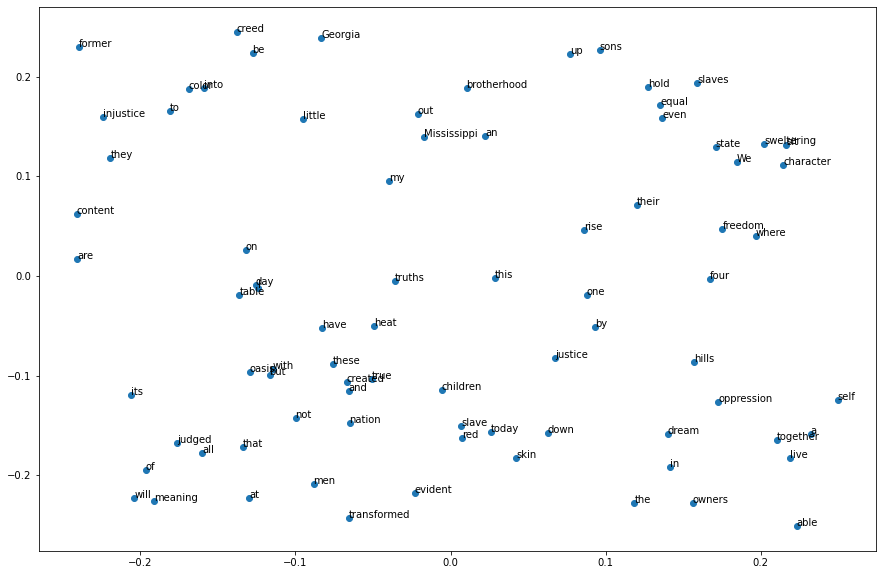

In [20]:
plot_graph(vocabs, x, y)

In [21]:
train_data = list(train.groupby('CLNT_ID')['CLAC3_NM'].unique())
test_data = list(test.groupby('CLNT_ID')['CLAC3_NM'].unique())

In [22]:
train_data[0]

array(['기타요가/필라테스소품 ', '거실수예소품 ', '블랜더 '], dtype=object)

In [39]:
#from google.colab import drive
#drive.mount('/content/drive')

In [23]:
def oversample(x, n):
  lst = []
  for i in x:
    tmp = []
    for j in range(n):
      random.shuffle(i)
      tmp += list(i)
    lst.append(tmp)
  return lst

In [24]:
w2v_input = oversample(train_data, 5)

In [25]:
w2v_input[0]

['거실수예소품 ',
 '기타요가/필라테스소품 ',
 '블랜더 ',
 '블랜더 ',
 '기타요가/필라테스소품 ',
 '거실수예소품 ',
 '거실수예소품 ',
 '기타요가/필라테스소품 ',
 '블랜더 ',
 '블랜더 ',
 '기타요가/필라테스소품 ',
 '거실수예소품 ',
 '기타요가/필라테스소품 ',
 '블랜더 ',
 '거실수예소품 ']

In [26]:
w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 5, min_count = 1, sg = 1)

In [27]:
train_mean_vector = []
for words in tqdm(train_data):
  tmp = np.zeros(30)
  cnt = 0
  for word in words:
    try:
      tmp += w2v[word]
      cnt += 1
    except:
      pass
  tmp /= cnt
  train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|███████████████████████████████████████████████████████████████████████| 263104/263104 [00:08<00:00, 31454.05it/s]


In [28]:
test_mean_vector = []
for words in tqdm(test_data):
  tmp = np.zeros(30)
  cnt = 0
  for word in words:
    try:
      tmp += w2v[word]
      cnt += 1
    except:
      pass
  tmp /= cnt
  test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|███████████████████████████████████████████████████████████████████████| 112760/112760 [00:03<00:00, 31542.47it/s]


In [34]:
train_mean_vector = pd.DataFrame(train_mean_vector).reset_index()
train_mean_vector.rename(columns = {'index' : 'CLNT_ID'}, inplace = True);train_mean_vector

,CLNT_ID,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0,-0.104231,-0.307691,-0.325131,-0.295482,0.149259,-0.308996,0.363759,0.328972,0.198383,...,0.087582,-0.088024,-0.159992,0.258658,0.440188,-0.165662,0.319151,0.253657,-0.015248,0.042252
1,1,-0.355491,-0.442936,0.053072,-0.056084,0.301866,-0.044792,0.148642,-0.369166,-0.070209,...,-0.038260,-0.170425,0.044154,0.108660,-0.168045,0.035758,0.299824,0.249283,-0.228840,-0.161608
2,2,-0.661490,-0.602716,-0.142504,-0.294435,0.303006,0.363046,0.374131,-0.470263,-0.595346,...,0.079379,-0.378129,0.244942,0.239091,-0.074294,-0.250940,0.195867,0.528235,0.039386,0.060661
3,3,-0.709240,-0.411581,-0.449419,0.076079,0.481682,0.196769,0.046090,0.060719,-0.210701,...,0.711208,-0.018229,-0.647786,-0.025195,-0.309270,0.138736,0.120840,0.053097,0.343193,0.167369
4,4,-0.474848,-0.470432,-0.172139,-0.112168,0.339516,-0.043442,0.039945,-0.139169,-0.066232,...,0.270052,-0.354628,-0.134732,-0.095096,-0.114295,-0.027225,0.407822,0.104000,0.023027,-0.116049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263099,263099,-0.516724,-0.632216,0.015858,-0.246969,0.441177,-0.225542,-0.146643,-0.169569,0.284160,...,0.240569,-0.345196,0.188761,-0.075105,-0.294823,-0.166732,0.484126,0.306658,-0.001813,-0.117206
263100,263100,-0.529808,-0.468030,-0.055274,-0.112656,0.408200,-0.093268,-0.028910,-0.211623,0.003809,...,0.226394,-0.416946,-0.087349,-0.042010,0.115425,-0.186954,0.414579,0.240150,0.039714,-0.288996
263101,263101,-0.465265,-0.427703,-0.107391,0.187763,0.006851,0.001314,0.591835,-0.158683,0.028870,...,0.438008,-0.308551,0.054166,-0.006384,0.205758,-0.286142,0.257977,0.211593,0.087610,-0.069652
263102,263102,-0.437655,0.375295,-0.402381,0.341987,-0.057620,-0.064854,-0.014663,0.428013,0.034861,...,0.416461,-0.340243,0.578091,0.349753,0.010684,-0.076173,0.154955,0.005353,0.079855,-0.504506


In [35]:
test_mean_vector = pd.DataFrame(test_mean_vector).reset_index()
test_mean_vector.rename(columns = {'index' : 'CLNT_ID'}, inplace = True);test_mean_vector

,CLNT_ID,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0,-0.175768,-0.235880,-0.244112,-0.257655,0.385833,-0.060835,0.246069,-0.587408,0.059130,...,-0.228854,0.098512,0.544907,0.096479,-0.150461,-0.026280,0.247753,-0.007145,0.220467,-0.339662
1,1,-0.213071,-0.451825,0.010422,-0.309698,0.404226,-0.020480,0.244386,-0.324116,0.007574,...,-0.282747,-0.148571,-0.357923,0.000750,-0.462207,-0.127292,0.144982,0.293351,0.051583,-0.321015
2,2,-0.406215,-0.647750,0.421914,0.300044,0.516290,0.150654,0.158917,-0.719012,-0.140396,...,0.237847,-0.077386,0.152279,-0.105256,0.171160,0.090897,0.709079,0.414894,-0.643780,-0.132290
3,3,-0.507793,-0.835580,-0.167034,-0.017492,0.504386,0.231848,0.360239,-0.475797,-0.351207,...,0.298664,-0.561690,0.171463,0.012840,-0.093677,-0.516391,0.286688,0.613834,-0.079550,0.379215
4,4,-0.128678,-0.481901,-0.151767,-0.306383,0.485800,0.095479,0.199239,-0.366877,-0.059386,...,0.090178,-0.337345,-0.154565,0.085362,-0.366527,-0.025986,0.194777,0.221387,0.008957,-0.184206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112755,112755,-0.597254,-0.684982,-0.269449,-0.183370,-0.157534,0.101635,0.319182,-0.340214,0.563602,...,-0.319455,-0.564637,0.241941,0.294874,-0.188439,0.548680,-0.073295,0.302453,-0.359784,-0.350235
112756,112756,-0.588889,0.028017,-0.087350,-0.235589,0.295692,-0.452788,0.192350,-0.175828,-0.013725,...,0.185338,-0.314757,-0.117435,-0.088020,-0.096710,-0.344094,0.620857,0.250045,-0.097768,-0.380722
112757,112757,-0.708448,-0.288184,0.002658,0.008601,0.087198,0.023573,0.131697,-0.253483,-0.167552,...,0.205661,-0.398189,-0.112928,0.136424,0.216325,-0.353010,0.425047,0.402037,0.058810,-0.247008
112758,112758,-0.372067,-1.026817,0.156390,0.161125,0.602365,-0.034540,-0.263244,-0.057729,-0.053883,...,0.697624,-0.647891,-0.029672,0.624218,-0.175953,0.118835,0.230283,0.051373,-0.489322,-0.226539


In [ ]:
#from sklearn.feature_selection import SelectFromModel
#smf = SelectFromModel(lgb, threshold='mean')
#smf.fit(train_mean_vector2, label)
#X_new1 = smf.transform(train_mean_vector2)
#X_te_new1 = smf.transform(test_mean_vector2)

In [ ]:
#X_new1 = pd.DataFrame(X_new1).reset_index()

In [ ]:
#X_new1

array([[0.00000e+00, 8.65000e+04, 4.32500e+04, ..., 6.30000e+01,
        6.30000e+01, 6.30000e+01],
       [1.00000e+00, 1.27600e+06, 7.97500e+04, ..., 9.20000e+01,
        1.10000e+02, 1.26000e+02],
       [2.00000e+00, 5.60000e+05, 5.09090e+04, ..., 7.60000e+01,
        2.34000e+02, 2.50000e+02],
       ...,
       [2.63101e+05, 1.35600e+05, 3.39000e+04, ..., 7.30000e+01,
        7.30000e+01, 7.30000e+01],
       [2.63102e+05, 5.94000e+04, 3.96000e+03, ..., 1.55000e+02,
        1.55000e+02, 1.55000e+02],
       [2.63103e+05, 2.96120e+06, 6.16920e+04, ..., 2.60000e+01,
        2.03000e+02, 3.88000e+02]])

In [36]:
train_mean_vector1 = pd.merge(data, train_mean_vector, on='CLNT_ID'); train_mean_vector1.shape

(263104, 227)

In [37]:
test_mean_vector['CLNT_ID'] = test_mean_vector['CLNT_ID']+263104
test_mean_vector1 = pd.merge(data_te, test_mean_vector, on='CLNT_ID')

In [39]:
test_mean_vector1.shape

(112760, 227)

In [42]:
train_mean_vector2 = train_mean_vector1.drop('CLNT_ID', axis=1, inplace=False)
test_mean_vector2 = test_mean_vector1.drop('CLNT_ID', axis=1, inplace=False)

In [45]:
train_mean_vector2.to_csv('C:/Users/leeji/ML_Session(D&A)/ML_Session_9주차/data_w2v.csv',index=False)
test_mean_vector2.to_csv('C:/Users/leeji/ML_Session(D&A)/ML_Session_9주차/data_te_w2v.csv',index=False)

In [29]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import log_loss

In [30]:
kfold = StratifiedKFold(n_splits = 4, random_state = 317)

In [31]:
lgb = LGBMClassifier()
lr = LogisticRegression()

In [43]:
# cross_val_score()로 교차 검증 정확도 확인
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lgb, train_mean_vector2, label, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-1.196  -1.2007 -1.2015 -1.2006 -1.2026]
평균 검증 정확도: -1.2003


In [ ]:
scores = cross_val_score(lgb, X_new1, label, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-1.1996 -1.2036 -1.2037 -1.2024 -1.2052]
평균 검증 정확도: -1.2029


In [44]:
lgb_params = {
    'max_depth' : [5, 10, -1],
    'n_estimators' : [100, 200, 300]
}
grid = GridSearchCV(lgb, lgb_params, scoring = 'neg_log_loss', cv = kfold, verbose = 1)
grid.fit(train_mean_vector2, label)
print(grid.best_estimator_)
print(grid.best_score_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

KeyboardInterrupt: 

In [ ]:
#submission = pd.read_csv('/content/drive/My Drive/ML_Session_9주차/dataset/sample_submission.csv')

In [ ]:
pred = grid.predict_proba(test_mean_vector2)
submission.loc[:,'F20':'M40'] = pred ; submission

,CLNT_ID,F20,F30,F40,M20,M30,M40
0,263104,0.166668,0.350715,0.393862,0.017699,0.025007,0.046049
1,263105,0.252262,0.463752,0.247723,0.007642,0.011975,0.016645
2,263106,0.114513,0.303993,0.245152,0.055791,0.110094,0.170458
3,263107,0.012614,0.727469,0.200745,0.000354,0.030571,0.028247
4,263108,0.172688,0.448299,0.274940,0.023754,0.043421,0.036900
...,...,...,...,...,...,...,...
112755,375859,0.132602,0.226448,0.161495,0.182980,0.202075,0.094401
112756,375860,0.046844,0.155891,0.763120,0.001083,0.004353,0.028708
112757,375861,0.054655,0.396863,0.462885,0.004508,0.029988,0.051100
112758,375862,0.104296,0.194280,0.256952,0.134644,0.154502,0.155326


In [ ]:
t = pd.Timestamp.now()
name = '이지평'
fname = f"{name}_submission_{t.month:11}{t.day:24}{t.hour:19}{t.minute:20}.csv"
submission.to_csv('/content/drive/My Drive/ML_Session_9주차/w2v-lgb.csv',index=False)

In [ ]:
lr_params = {'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 3, 5]}
grid = grid = GridSearchCV(lr, lr_params, scoring = 'neg_log_loss', cv = kfold, verbose = 1)
grid.fit(train_mean_vector, label)
print(grid.best_estimator_)
print(grid.best_score_)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  7.8min finished


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=5, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-1.2489118596897988
